# Check Inference on Synthetic Observations

In [96]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
import os

import h5py
import numpy as np
import matplotlib.pyplot as plt
from prospect.utils.obsutils import fix_obs

from agnfinder.prospector import visualise, main, cpz_builders

In [110]:
os.chdir('/home/mike/repos/agnfinder')

In [111]:
!pwd

/home/mike/repos/agnfinder


In [191]:
galaxy_index = 1
galaxy = main.load_galaxy(galaxy_index)
redshift = galaxy['redshift']

agn_mass = True
agn_eb_v = True
obscured_torus = True

In [192]:
run_params, obs, model, sps = main.construct_problem(galaxy, redshift=redshift, agn_mass=agn_mass, agn_eb_v=agn_eb_v, obscured_torus=obscured_torus)

sps should be an instance of my custom CSPSpecBasisAGN class

In [193]:
sps

And model should include agn_mass and agn_eb_v

In [194]:
model.free_params

['mass', 'logzsol', 'dust2', 'tage', 'tau', 'agn_mass', 'agn_eb_v']

In [196]:
model_spectrum, model_photometry, _ = model.sed(model.theta, obs, sps)  # trigger fsps calculation, takes a couple of minutes - then cached

In [206]:
model_photometry

array([5.95011029e-05, 8.28615071e-05, 5.19735346e-05, 3.80285618e-05,
       3.06891545e-05, 3.44257179e-05, 2.81671731e-05, 1.55281129e-05,
       1.60782178e-05, 2.39415863e-05, 2.51881443e-05, 2.84039624e-05,
       2.69540862e-05, 2.85964750e-05])

In [207]:
sps.quasar_flux

array([1.04602798e-12, 1.06446003e-12, 1.07659756e-12, ...,
       5.18043417e-17, 5.09690227e-17, 5.01457905e-17])

In [197]:
assert max(sps.quasar_flux) > min(sps.quasar_flux)

## How does the SED change as we vary the AGN parameters?

In [214]:
model.free_params

['mass', 'logzsol', 'dust2', 'tage', 'tau', 'agn_mass', 'agn_eb_v']

In [227]:
theta_no_agn = model.theta.copy()
theta_agn = model.theta.copy()

# agn
theta_agn[-3] = .1  # notice how this is quite low vs my prior, relative agn contribution obv. depends on the galaxy mass
theta_no_agn[-3] = 0

# no extinction
theta_agn[-2] = 0
theta_no_agn[-2] = 0

In [228]:
model_spectrum, model_photometry, _ = model.sed(theta_agn, obs, sps)

In [229]:
model_spectrum_no_agn, model_photometry_no_agn, _ = model.sed(theta_no_agn, obs, sps)

In [230]:
(model_spectrum - model_spectrum_no_agn).max()

2.9111885391733975e-05

In [231]:
(model_photometry - model_photometry_no_agn).max()

8.28436680685369e-06

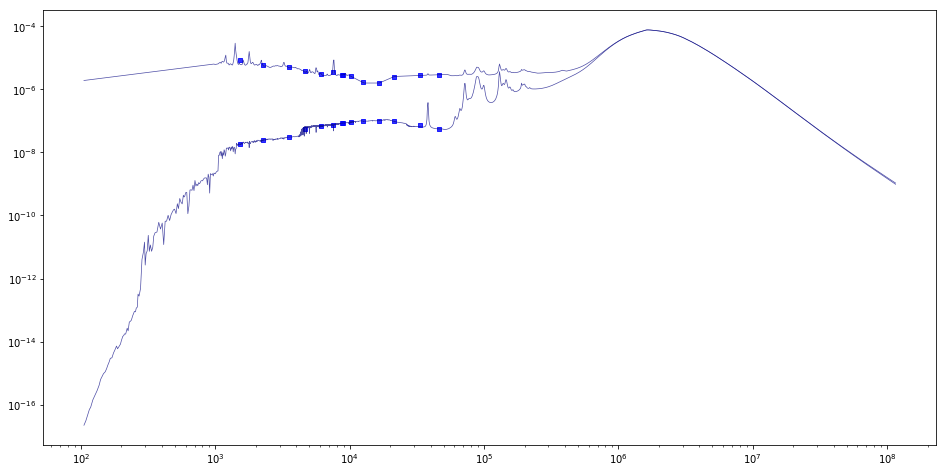

In [232]:
fig, ax = plt.subplots(figsize=(16, 8))
visualise.plot_model_at_obs(ax, model, theta_agn, synthetic_obs, sps)  
visualise.plot_model_at_obs(ax, model, theta_no_agn, synthetic_obs, sps)  

What if we add extinction?

In [257]:
theta_extinction = theta_agn.copy()
theta_no_extinction = theta_agn.copy()

# no extinction
theta_extinction[-2] = 0.2
theta_no_extinction[-2] = 0.

In [258]:
sps.quasar_flux

array([1.04602798e-13, 1.06446003e-13, 1.07659756e-13, ...,
       5.18043417e-18, 5.09690227e-18, 5.01457905e-18])

In [259]:
sps.extincted_quasar_flux

array([1.04602798e-13, 1.06446003e-13, 1.07659756e-13, ...,
       5.18043417e-18, 5.09690227e-18, 5.01457905e-18])

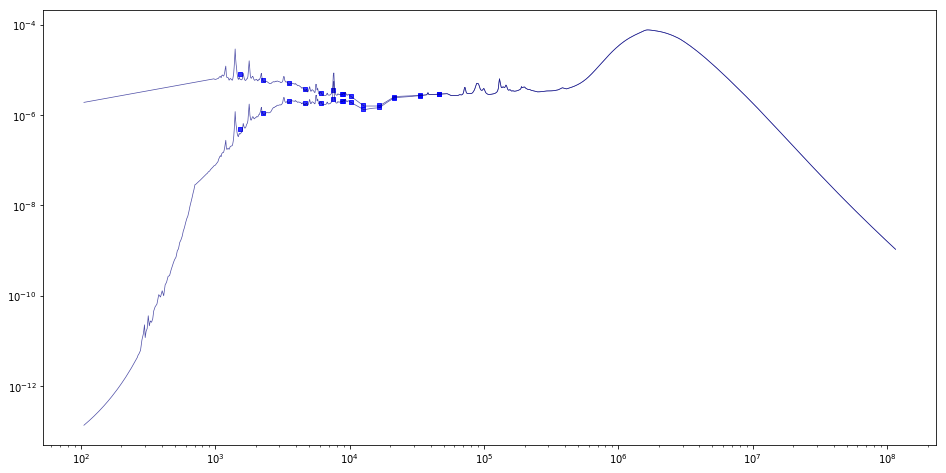

In [262]:
fig, ax = plt.subplots(figsize=(16, 8))
visualise.plot_model_at_obs(ax, model, theta_extinction, synthetic_obs, sps)  
visualise.plot_model_at_obs(ax, model, theta_no_extinction, synthetic_obs, sps)  

Looking good!

## Can we recover the original parameters?

In [264]:
def make_synthetic_obs_from_model(real_obs, maggies, snr=10.):
    synthetic_obs = {}
    synthetic_obs["filters"] =  real_obs['filters']
    synthetic_obs["maggies"] = maggies
    synthetic_obs['maggies_unc'] = maggies / snr

    synthetic_obs["phot_mask"] = np.array([True for _ in synthetic_obs['filters']])
    synthetic_obs["phot_wave"] = np.array([f.wave_effective for f in synthetic_obs["filters"]])
    synthetic_obs["wavelength"] = None
    synthetic_obs["spectrum"] = None
    synthetic_obs['unc'] = None
    synthetic_obs['mask'] = None
    synthetic_obs = fix_obs(synthetic_obs)
    return synthetic_obs


In [265]:
theta_to_recover = theta_extinction

In [266]:
model_spectrum, model_photometry, _ = model.sed(theta_to_recover, obs, sps)  # trigger fsps calculation, takes a couple of minutes - then cached

In [268]:
synthetic_obs = make_synthetic_obs_from_model(obs, model_photometry)

### Max Likelihood (starting from correct values, so unhelpful!)

In [ ]:
# theta_best, time_elapsed = main.fit_galaxy(run_params, synthetic_obs, model, sps)

### MCMC

In [270]:
samples, mcmc_time_elapsed = main.mcmc_galaxy(run_params, synthetic_obs, model, sps, initial_theta=None, test=False)

/home/mike/repos/prospector/prospect/models/priors.py:104: RuntimeWarning: divide by zero encountered in log
  lnp = np.log(p)


In [271]:
synthetic_obs = build_synthetic_obs_from_model(obs, model_photometry, snr=10.)

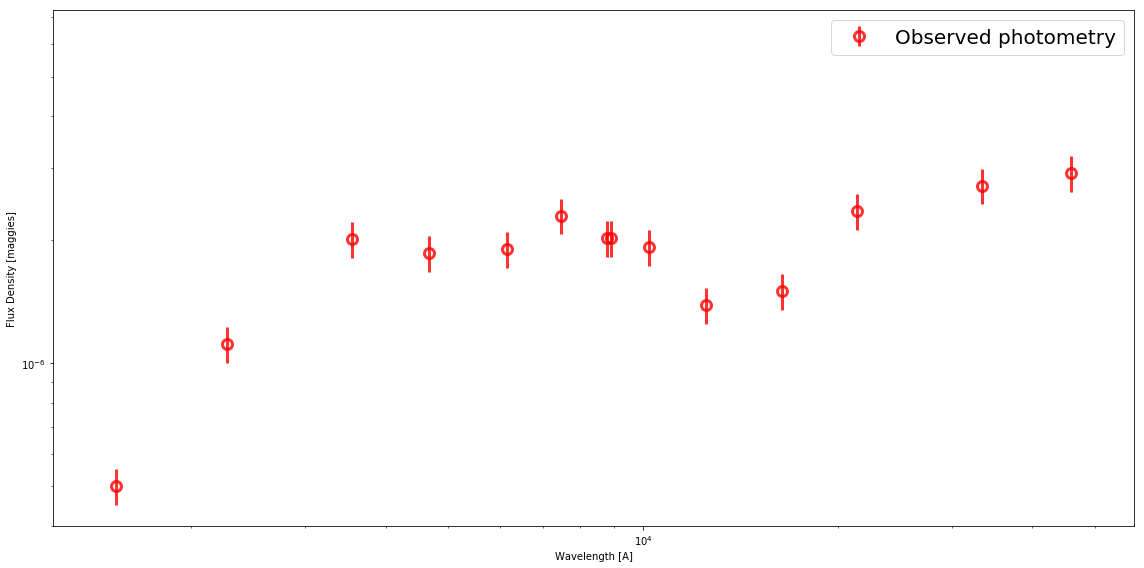

In [272]:
visualise.visualise_obs(synthetic_obs)

In [273]:
name = 'inference_to_recover_theta'
output_dir = '/home/mike/repos/agnfinder/results'

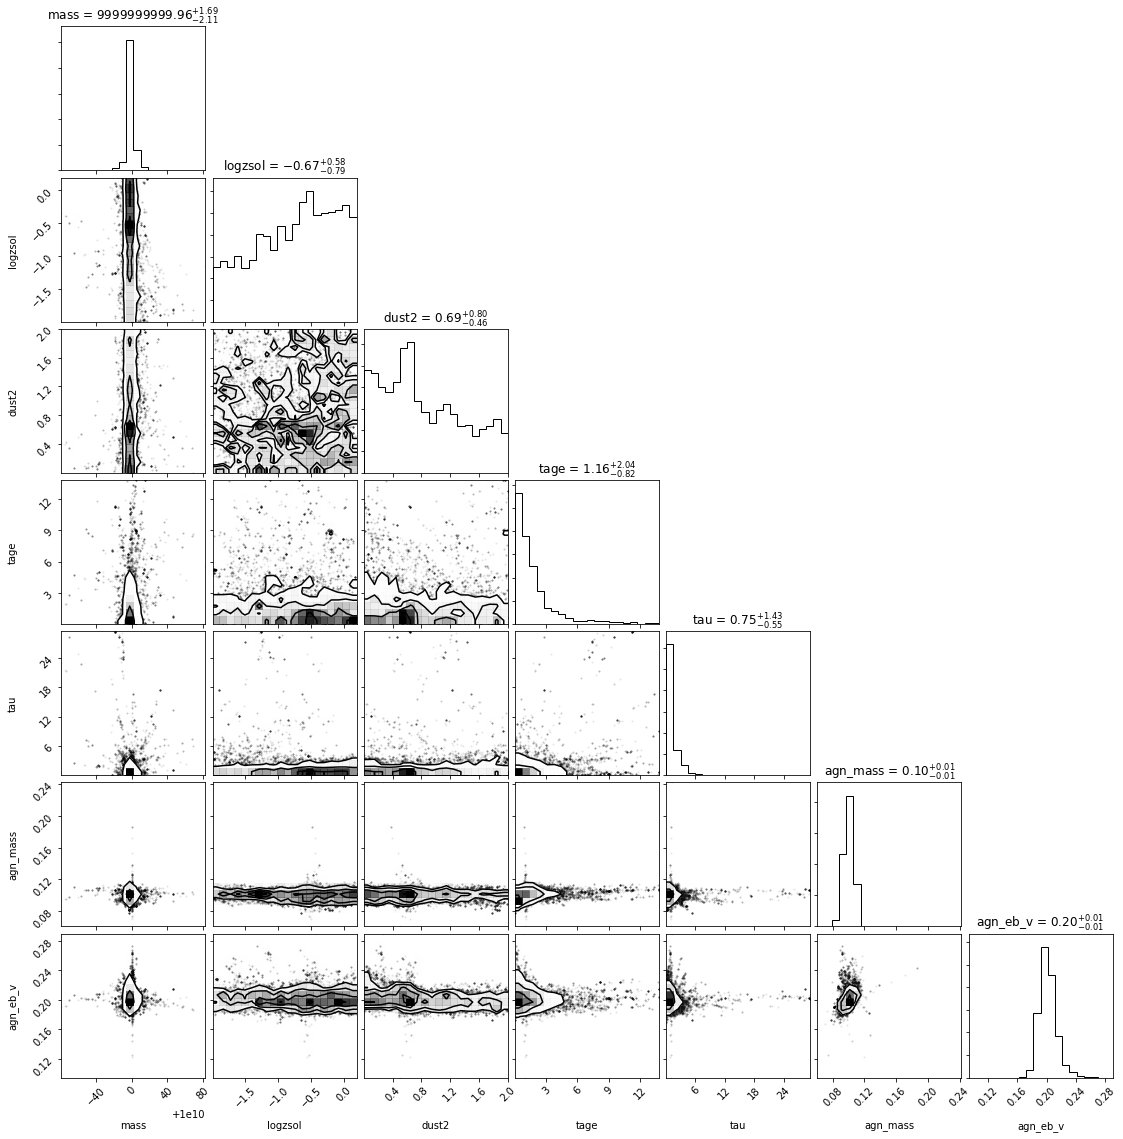

In [278]:
sample_loc = os.path.join(output_dir, '{}_mcmc_samples.h5py'.format(name))
main.save_samples(samples, model, sample_loc)
corner_loc = os.path.join(output_dir, '{}_mcmc_corner.png'.format(name))
main.save_corner(samples[int(len(samples)/2):], model, corner_loc)  # nested sampling has no burn-in phase, early samples are bad

In [279]:
theta_to_recover

array([ 1.e+10, -5.e-01,  6.e-01,  1.e+00,  1.e+00,  1.e-01,  2.e-01])

In [281]:
import corner

In [292]:
for index in range(len(theta_to_recover)):
    print('Name: {}'.format(model.free_params[index]))
    print('True value: {:3.1E}'.format(theta_to_recover[index]))
    low, med, up = corner.quantile(samples[:, index], [.1, .5, .9])
    print('Estimate: {:3.1E} (min {:3.2E}, max {:3.3E})'.format(low, med, up))
    print('\n')
    

Name: mass
True value: 1.0E+10
Estimate: 1.0E+10 (min 1.00E+10, max 1.000E+10)


Name: logzsol
True value: -5.0E-01
Estimate: -1.7E+00 (min -7.34E-01, max -6.269E-03)


Name: dust2
True value: 6.0E-01
Estimate: 1.3E-01 (min 6.58E-01, max 1.716E+00)


Name: tage
True value: 1.0E+00
Estimate: 2.9E-01 (min 1.18E+00, max 5.064E+00)


Name: tau
True value: 1.0E+00
Estimate: 1.7E-01 (min 8.85E-01, max 3.358E+00)


Name: agn_mass
True value: 1.0E-01
Estimate: 9.4E-02 (min 1.01E-01, max 1.082E-01)


Name: agn_eb_v
True value: 2.0E-01
Estimate: 1.9E-01 (min 2.02E-01, max 2.201E-01)




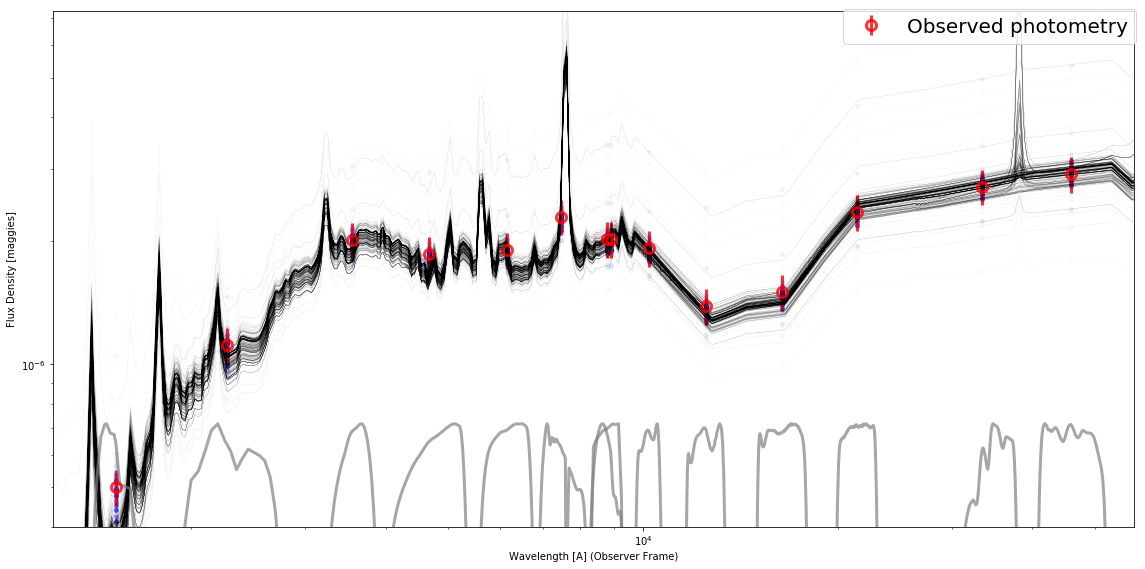

In [297]:
traces_loc = os.path.join(output_dir, '{}_mcmc_traces.png'.format(name))
main.save_sed_traces(samples[-2000:], synthetic_obs, model, sps, traces_loc)


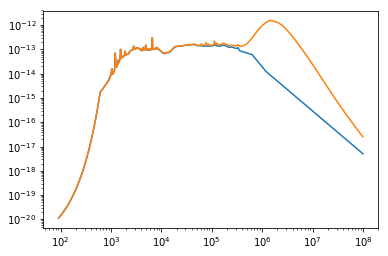

In [312]:
plt.loglog(sps.wavelengths, sps.extincted_quasar_flux)
_, spectra, _ = sps.get_galaxy_spectrum()
plt.loglog(sps.wavelengths, spectra)

In [308]:
len(sps.wavelengths)

5994

In [301]:
sps.extincted_quasar_flux.sum() / model_spectrum.sum()

2.72253954012484e-08

In [304]:
len(sps.extincted_quasar_flux)

5994

In [305]:
len(model_spectrum)

5994